<a href="https://colab.research.google.com/github/openknowledge/mlops-m3/blob/main/insurance-prediction/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase I: Exploration


In [1]:
# If this gives red output everything is fine
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
# disable gpus, can also give red output and everything is just fine
tf.config.set_visible_devices([], 'GPU')

In [3]:
tf.random.set_seed(42)

In [4]:
import numpy as np
np.__version__

'1.22.4'

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [6]:
# https://github.com/AndreasMadsen/python-lrcurve
# uncomment for Colab
!pip install -q lrcurve

In [7]:
from lrcurve import KerasLearningCurve

# Step 1: Loading and exploring our data set

In [8]:
import pandas as pd

df = pd.read_csv('https://github.com/openknowledge/mlops-m3/raw/main/insurance-prediction/datasets/insurance_prediction/reference.csv.gz', delimiter=';')
# df = pd.read_csv(f'../../datasets/insurance_prediction/reference.csv', delimiter=';')

In [9]:
df.head(10)

,training,age,emergency_braking,braking_distance,power,miles,risk,group_name,group
0,0,41.951100,0,40.933328,122.238329,98.509765,3.700073,high,0
1,0,24.368286,1,44.797317,113.765298,46.324178,2.447873,medium,1
2,0,18.314649,1,41.587241,143.427269,76.862968,4.079834,high,0
3,0,51.265254,1,47.266716,111.578133,102.697069,5.087831,high,0
4,0,23.578861,0,42.835319,145.994235,63.690055,3.739299,high,0
5,0,29.506037,1,46.547745,139.820214,66.610999,3.130142,high,0
6,0,21.289385,1,40.666499,134.749599,63.146964,1.774027,medium,1
7,1,47.459483,0,35.168550,142.215391,123.385272,0.084924,low,2
8,1,20.573680,1,41.798826,114.677871,103.853842,-0.033755,low,2
9,0,24.639606,1,40.801391,162.457198,44.292386,2.456763,medium,1


In [10]:
df.describe()

,training,age,emergency_braking,braking_distance,power,miles,risk,group
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.183617,0.901333
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.481164,0.815705
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.289352,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.708085,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.386835,1.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.874869,2.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.343054,2.000000


# Step 2: Training a neural network

In [11]:
X = df.drop(['risk', 'group', 'group_name'], axis='columns').values

In [12]:
y = df['group'].values
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([580, 488, 432]))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 6), (300, 6), (1200,), (300,))

## Normalization

In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [15]:
normalizer.adapt(X_train)

In [16]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.7
neurons_per_layer = 100
# neurons_per_layer = 50

model = tf.keras.Sequential()
model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(neurons_per_layer, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden3'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 hidden1 (Dense)             (None, 100)               700       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               1

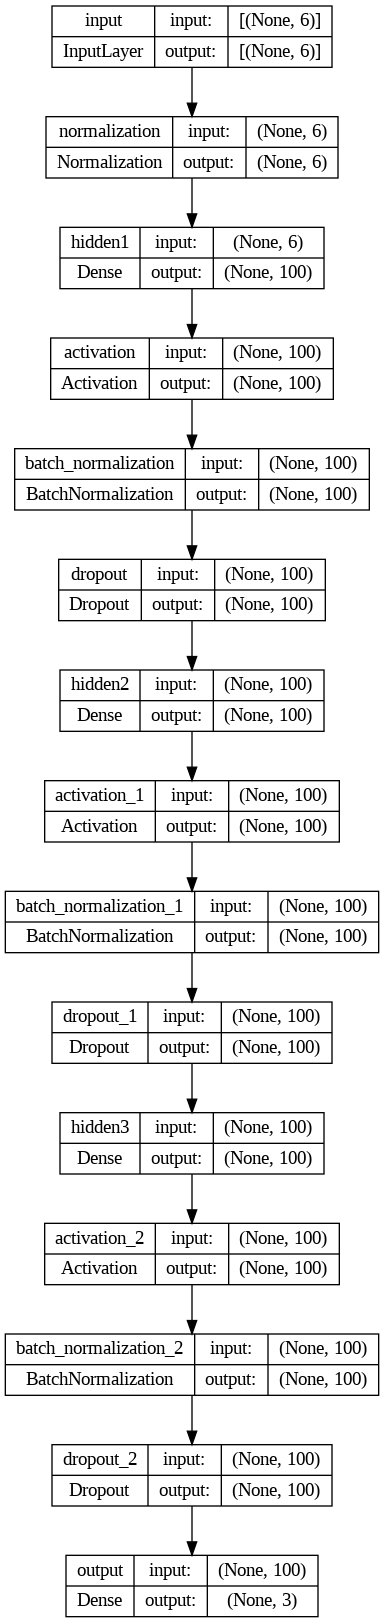

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
%%time 

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 50

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 12.9 s, sys: 388 ms, total: 13.3 s
Wall time: 22.8 s


In [19]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8725


(0.3588937222957611, 0.8725000023841858)

In [20]:
test_loss, test_metric = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 2ms/step - loss: 0.3513 - accuracy: 0.9033


(0.3512682020664215, 0.903333306312561)

# Invariant Properties of Model

## Accuracy range and lack of overfitting

In [21]:
# 85% is sufficient for our use case
assert train_metric > .85

In [22]:
assert test_metric > .85

In [23]:
assert abs(train_metric - test_metric) < .05

In [24]:
# we can not be too good

assert test_metric < .95
assert train_metric < .95

## Invariants of the model itself (without using data on it)
Could be
* effective depth of tree (if decision tree has been used as architecture instead of NN)
* distribution of weights
* actual normalization

**We do use these properties as we want to treat the model as a black box to make it interchangable**

# Invariants also useful for monitoring and analyzis - not using GT

In [25]:
y_pred = model.predict(X).argmax(axis=1)
y_pred.shape

47/47 [==============================] - 0s 2ms/step


(1500,)

## Distribution of Output Class

In [26]:
values, counts = np.unique(y_pred, return_counts=True)
values, counts

(array([0, 1, 2]), array([542, 522, 436]))

In [27]:
# equal distribution around classes expected
tolerance = 0.15
expected_count = len(X) / 3
lower_bound = int(expected_count * (1 - tolerance))
upper_bound = int(expected_count * (1 + tolerance))
print(f'{lower_bound}-{upper_bound}')
                  
for count in counts:
    print(count)
    assert count in range(lower_bound, upper_bound)

425-575
542
522
436


## Distribution of confidence

In [28]:
y_pred_probas = model.predict(X).max(axis=1)
y_pred_probas.shape

47/47 [==============================] - 0s 2ms/step


(1500,)

In [29]:
y_pred_probas.min(), y_pred_probas.mean(), y_pred_probas.max()

(0.46559837, 0.766381, 0.9999071)

In [30]:
assert y_pred_probas.min() > .4

In [31]:
assert y_pred_probas.mean() > 0.7

In [32]:
assert y_pred_probas.max() > 0.99

# Saving Model

In [33]:
model.save('classifier.h5', save_format='h5')

In [34]:
model.save('classifier', save_format='tf')

In [35]:
!ls -l

total 732
drwxr-xr-x 4 root root   4096 May  8 12:08 classifier
-rw-r--r-- 1 root root 333608 May  8 12:08 classifier.h5
-rw-r--r-- 1 root root 289659 May  8 12:04 classifier.tgz
-rw-r--r-- 1 root root 110677 May  8 12:08 model.png
drwxr-xr-x 1 root root   4096 May  3 13:31 sample_data


In [36]:
!ls -l classifier/

total 392
drwxr-xr-x 2 root root   4096 May  8 12:04 assets
-rw-r--r-- 1 root root     56 May  8 12:08 fingerprint.pb
-rw-r--r-- 1 root root  23997 May  8 12:08 keras_metadata.pb
-rw-r--r-- 1 root root 361007 May  8 12:08 saved_model.pb
drwxr-xr-x 2 root root   4096 May  8 12:08 variables


In [37]:
!tar czvf classifier.tgz ./classifier

./classifier/
./classifier/keras_metadata.pb
./classifier/assets/
./classifier/fingerprint.pb
./classifier/variables/
./classifier/variables/variables.index
./classifier/variables/variables.data-00000-of-00001
./classifier/saved_model.pb


In [38]:
!ls -l

total 732
drwxr-xr-x 4 root root   4096 May  8 12:08 classifier
-rw-r--r-- 1 root root 333608 May  8 12:08 classifier.h5
-rw-r--r-- 1 root root 289695 May  8 12:08 classifier.tgz
-rw-r--r-- 1 root root 110677 May  8 12:08 model.png
drwxr-xr-x 1 root root   4096 May  3 13:31 sample_data
